In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple
from dataclasses import dataclass
from copy import deepcopy

In [ ]:
# Load the concrete data
df = pd.read_csv("data/concrete_data.csv")

# Display the data
df

In [ ]:
# Separate into train and test datasets

train_df = df.sample(frac=0.7, random_state=42) # random state ensures we always get the same sample
test_df = df.drop(train_df.index)
train_df.columns

In [ ]:
# copy the target column from the input data into separate numpy arrays

train_targets = train_df[' concrete_compressive_strength'].to_numpy()
test_targets = test_df[' concrete_compressive_strength'].to_numpy()

test_targets

In [ ]:
# drop the target column from the input data to create input feature arrays

train_features = train_df.drop(columns=[' concrete_compressive_strength']).to_numpy()
test_features = test_df.drop(columns=[' concrete_compressive_strength']).to_numpy()

test_features

In [ ]:
def mean_squared_error(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return np.mean((y_true - y_pred) ** 2)

def mean_absolute_error(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return np.mean(np.abs(y_true - y_pred))

In [ ]:
class Layer:
    def __init__(self):
        self.isVectorizable = False

    def forward(self, input_data: np.ndarray) -> np.ndarray:
        raise NotImplementedError("Forward method not implemented.")

    def randomize(self) -> None:
        pass

In [ ]:
class ActivationSigmoid(Layer):
    def forward(self, input_data: np.ndarray) -> np.ndarray:
        return 1 / (1 + np.exp(-input_data))

class ActivationReLU(Layer):
    def forward(self, input_data: np.ndarray) -> np.ndarray:
        return np.maximum(0, input_data)

class ActivationTanh(Layer):
    def forward(self, input_data: np.ndarray) -> np.ndarray:
        return np.tanh(input_data)

In [ ]:
# create a layer class for the MLP

class Linear(Layer):
    def __init__(self, size_input: int, size_hidden: int):
        """Initialize with weights and biases."""
        self.size_input = size_input
        self.size_hidden = size_hidden
        self.weights = self.init_weights()
        self.bias = self.init_biases()
        self.isVectorizable = True

    def init_weights(self):
        """Initialize weights."""
        return np.random.randn(self.size_hidden, self.size_input) * 0.01

    def init_biases(self):
        """Initialize biases."""
        return np.full((self.size_hidden, 1), 0.001)

    def randomize(self):
        """Randomize weights and biases."""
        self.weights = self.init_weights()
        self.bias = self.init_biases()

    def forward(self, X):
        return np.dot(self.weights, X) + self.bias

    def to_vector(self) -> np.ndarray:
        """Flatten weights and biases into a single vector."""
        return np.concatenate((self.weights.flatten(), self.bias.flatten()))

    def from_vector(self, vector: np.ndarray) -> int:
        """Set weights and biases from a single vector."""
        self.weights = vector[:self.weights.size].reshape(self.weights.shape)
        self.bias = vector[self.weights.size:].reshape(self.bias.shape)

In [ ]:
# Test the Linear class
layer = Linear(size_input=5, size_hidden=3)
X_sample = np.random.randn(1, 5).T
output = layer.forward(X_sample)

vector = layer.to_vector()
layer2 = Linear(size_input=5, size_hidden=3)
layer2.from_vector(vector)

print(f"""
bias:
{layer.bias}
weights:
{layer.weights}
input:
{X_sample}
output:
{output}

vector:
{vector}
layer2 bias:
{layer2.bias}
layer2 weights:
{layer2.weights}
""")

In [ ]:
class Sequential:
    def __init__(self, *layers: Layer, randomize: bool = True):
        self.layers = layers
        self.vectorizable_layers: List[Linear] = [layer for layer in self.layers if layer.isVectorizable]
        self.vector_indexes = []
        index = 0
        for layer in self.vectorizable_layers:
            size_layer_params = layer.weights.size + layer.bias.size
            self.vector_indexes.append((index, index + size_layer_params))
            index += size_layer_params

        if randomize:
            self.randomize()

    def randomize(self):
        for layer in self.layers:
            layer.randomize()

    def forward(self, X: np.ndarray) -> np.ndarray:
        output = X
        for layer in self.layers:
            output = layer.forward(output)
        return output

    def to_vector(self) -> np.ndarray:
        """Concatenate parameters from all layers into a single vector."""
        param_vector = np.array([])
        for layer in self.vectorizable_layers:
            param_vector = np.concatenate((param_vector, layer.to_vector()))
        return param_vector

    def from_vector(self, param_vector: np.ndarray):
        """Set parameters from all layers from a single vector."""
        for i in range(len(self.vectorizable_layers)):
            start_idx, end_idx = self.vector_indexes[i]
            self.vectorizable_layers[i].from_vector(param_vector[start_idx:end_idx])


In [ ]:
# Test the Sequential class

mlp = Sequential(
    Linear(size_input=5, size_hidden=3),
    ActivationReLU(),
    Linear(size_input=3, size_hidden=4),
    ActivationSigmoid(),
    Linear(size_input=4, size_hidden=1)
)
X_sample = np.random.randn(1, 5).T
output = mlp.forward(X_sample)
vector = mlp.to_vector()
print(f"""
input:
{X_sample}
output:
{output}

vector:
{vector}
""")

mlp.randomize()
print(f"""
initial model2 output:
{mlp.forward(X_sample)}
""")

mlp.from_vector(vector)
print(f"""model2 output after from_vector:
{mlp.forward(X_sample)}
""")

In [ ]:
# Creation of AI class for training the MLP with our PSO

@dataclass
class AccelerationCoefficients:
    inertia_weight: float
    cognitive_weight: float
    social_weight: float
    global_best_weight: float
    jump_size: float
    max_velocity: float
    max_position: float

class Particle:
    def __init__(self, position: np.ndarray, accel_coeff: AccelerationCoefficients, fitness: float):
        self.accel_coeff = accel_coeff
        # Initialize other attributes like position, velocity, personal best, etc.
        self.position = position
        self.velocity = np.random.randn(position.shape[0]) * 0.1
        self.fittest = fitness
        self.informants: List[Particle] = []

        self.best_personal: np.ndarray = position.copy()

    def get_best_informant(self):
        informant_fittest = None
        best_informant = None
        for informant in self.informants:
            if best_informant is None or informant.fittest < informant_fittest:
                informant_fittest = informant.fittest
                best_informant = informant
        return best_informant.position

    def update_velocity(self, best_global):
        best_informant = self.get_best_informant()
        for i in range(len(self.position)):
            b = np.random.random() * self.accel_coeff.cognitive_weight
            c = np.random.random() * self.accel_coeff.social_weight
            d = np.random.random() * self.accel_coeff.global_best_weight
            inertia = self.accel_coeff.inertia_weight * self.velocity[i]
            velocity_cognitive = b * (self.best_personal[i] - self.position[i])
            velocity_social = c * (best_informant[i] - self.position[i])
            velocity_global = d * (best_global[i] - self.position[i])
            new_velocity = inertia + velocity_cognitive + velocity_social + velocity_global
            self.velocity[i] = np.clip(new_velocity, -self.accel_coeff.max_velocity, self.accel_coeff.max_velocity)

    def update_position(self):
        self.position += self.velocity * self.accel_coeff.jump_size
        self.position = np.clip(self.position, -self.accel_coeff.max_position, self.accel_coeff.max_position)

class ParticleSwarmOptimisation:
    def __init__(
            self,
            X: np.ndarray[tuple[int, int]],
            Y: np.ndarray[tuple[int]],
            swarm_size: int,
            epochs: int,
            accel_coeff: AccelerationCoefficients,
            num_informants: int,
            loss_function,
            model: Sequential,
        ):
        self.epochs = epochs
        self.accel_coeff = accel_coeff
        self.swarm_size = swarm_size
        self.num_informants = num_informants

        self.X = X
        self.Y = Y

        self.loss_function = loss_function
        self.model = model

        self.population: List[Particle] = []
        for _ in range(swarm_size):
            self.model.randomize()
            particle_fitness = self.loss_function(self.Y, self.model.forward(self.X))
            self.population.append(Particle(position=self.model.to_vector(), accel_coeff=accel_coeff, fitness=particle_fitness))

        self.best_global: np.ndarray = self.population[0].position.copy()
        self.best_global_fitness: float = self.population[0].fittest

    def update_informants(self):
        if self.num_informants >= self.swarm_size:
            raise ValueError("Number of informants must be less than swarm size.")
        for particle in self.population:
            others = [p for p in self.population if p is not particle]
            particle.informants = np.random.choice(others, size=self.num_informants, replace=False)

    def update_best_global(self, epoch):
        loss = 0.0
        for particle in self.population:
            self.model.from_vector(particle.position)
            # if loss == 0.0:
            #     print(f"Particle position sample: {particle.position[:5]}")
            fitness = self.loss_function(self.Y, self.model.forward(self.X))
            loss += fitness
            # print(f"Particle fitness: {fitness}")
            if fitness < particle.fittest:
                particle.best_personal = particle.position.copy()
                particle.fittest = fitness
                if self.best_global_fitness is None or fitness < self.best_global_fitness:
                    # print(f"{epoch}: New best found: {fitness}")
                    self.best_global = particle.position.copy()
                    self.best_global_fitness = fitness
        return loss / self.swarm_size

    def update_velocities(self):
        for particle in self.population:
            particle.update_velocity(self.best_global)

    def update_positions(self):
        for particle in self.population:
            particle.update_position()

    def train(self):
        self.update_informants()
        losses = []
        for epoch in range(self.epochs):
            loss = self.update_best_global(epoch)
            losses.append(loss)
            self.update_velocities()
            self.update_positions()
            # print(f"Epoch {epoch}, Loss: {loss}")
        return (self.best_global, self.best_global_fitness, losses)

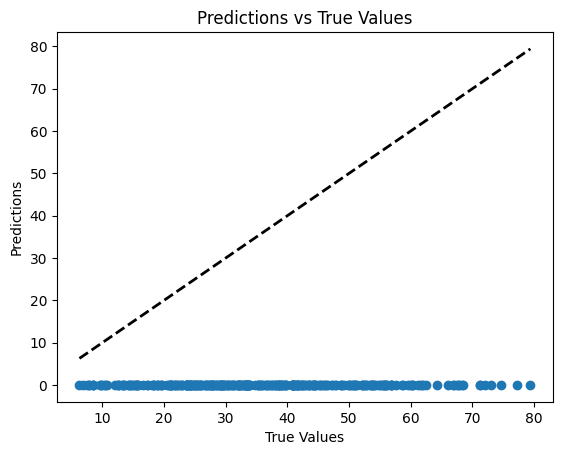

Final particle fitness: 60.32460507784239
Final particle position sample: [ 0.10895417 -0.13196297 -0.09513001  0.04077379 -0.08730951]


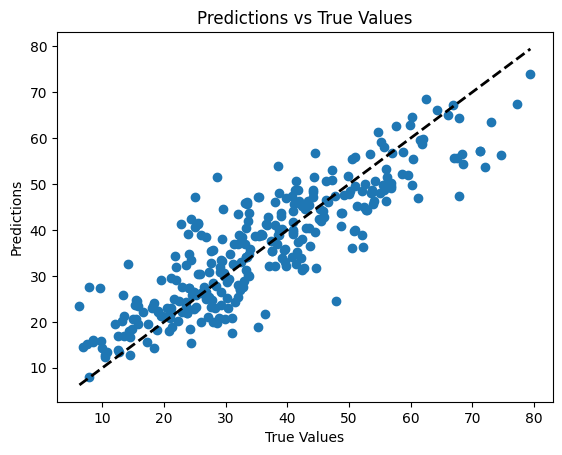

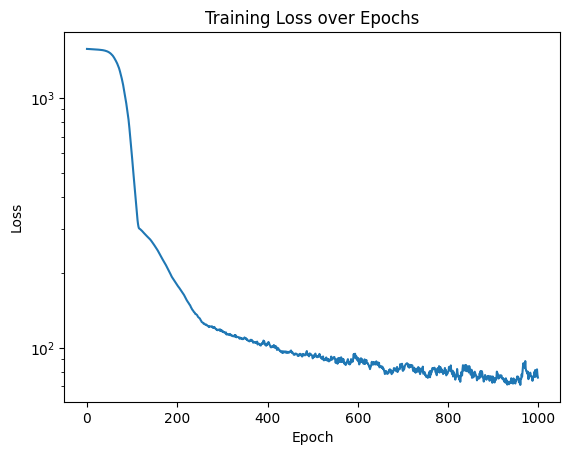

In [ ]:
mlp = Sequential(
    Linear(size_input=train_features.shape[1], size_hidden=10),
    ActivationReLU(),
    Linear(size_input=10, size_hidden=10),
    ActivationReLU(),
    Linear(size_input=10, size_hidden=10),
    ActivationReLU(),
    Linear(size_input=10, size_hidden=1),
)

predictions = mlp.forward(test_features.T)

plt.scatter(test_targets, predictions)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("Predictions vs True Values")
plt.plot([test_targets.min(), test_targets.max()], [test_targets.min(), test_targets.max()], 'k--', lw=2)
plt.show()

pso = ParticleSwarmOptimisation(
    X=train_features.T,
    Y=train_targets,
    swarm_size=100,
    epochs=1000,
    accel_coeff=AccelerationCoefficients(
        inertia_weight=0.5,
        cognitive_weight=1.5,
        social_weight=1.5,
        global_best_weight=0.5,
        jump_size=0.1,
        max_velocity=0.01,
        max_position=5.0,
    ),
    num_informants=5,
    loss_function=mean_squared_error,
    model=mlp
)

(final_position, final_score, losses) = pso.train()
print(f"Final particle fitness: {final_score}")
print(f"Final particle position sample: {final_position[:5]}")

mlp.from_vector(final_position)
predictions = mlp.forward(test_features.T)

plt.scatter(test_targets, predictions)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("Predictions vs True Values")
plt.plot([test_targets.min(), test_targets.max()], [test_targets.min(), test_targets.max()], 'k--', lw=2)
plt.show()

plt.plot(losses)
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.show()

print("Final loss", losses[-1])

In [ ]:
print(train_targets)